In [1]:
import pickle
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import os
import cv2
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import matplotlib.pyplot as plt
import time

In [2]:
types = ['flair','t1','t1Gd','t2',
         'ManuallyCorrected','GlistrBoost']
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, "Data/")
flair_path = os.path.join(data_dir, 'flair')
flair_files = os.listdir(flair_path)
img = nib.load(os.path.join(flair_path, flair_files[0]))

In [4]:
flair_data_path = os.path.join(data_dir, 'flair')
t1_data_path = os.path.join(data_dir, 't1')
t1gd_data_path = os.path.join(data_dir, 't1Gd')
t2_data_path = os.path.join(data_dir, 't2')
mask_data_path = os.path.join(data_dir, 'ManuallyCorrected')

flair_files = os.listdir(flair_path)
t1_files = os.listdir(t1_data_path)
t1gd_files = os.listdir(t1gd_data_path)
t2_files = os.listdir(t2_data_path)
mask_files = os.listdir(mask_data_path)

hdd_data_dir = "/Volumes/TumorData/Data"
numpy_dest = os.path.join(hdd_data_dir, "NumpyArraysLSmall2D")


In [16]:
# Load the data from files:



numpy_files = os.listdir(numpy_dest)
numpy_files

['Flair_Array_0_Classes.npy',
 'Flair_Array_0_Features.npy',
 'Flair_Array_1_Classes.npy',
 'Flair_Array_1_Features.npy',
 'Flair_Array_2_Classes.npy',
 'Flair_Array_2_Features.npy',
 'Flair_Array_3_Classes.npy',
 'Flair_Array_3_Features.npy',
 'Flair_Array_4_Classes.npy',
 'Flair_Array_4_Features.npy',
 'Flair_Array_5_Classes.npy',
 'Flair_Array_5_Features.npy',
 'Flair_Array_6_Classes.npy',
 'Flair_Array_6_Features.npy',
 'Flair_Array_7_Classes.npy',
 'Flair_Array_7_Features.npy',
 'Flair_Array_8_Classes.npy',
 'Flair_Array_8_Features.npy',
 'Flair_Array_9_Classes.npy',
 'Flair_Array_9_Features.npy',
 'Flair_Array_10_Classes.npy',
 'Flair_Array_10_Features.npy',
 'Flair_Array_11_Classes.npy',
 'Flair_Array_11_Features.npy',
 'Flair_Array_12_Classes.npy',
 'Flair_Array_12_Features.npy',
 'Flair_Array_13_Classes.npy',
 'Flair_Array_13_Features.npy',
 'Flair_Array_14_Classes.npy',
 'Flair_Array_14_Features.npy',
 'Flair_Array_15_Classes.npy',
 'Flair_Array_15_Features.npy',
 'Flair_Arra

In [17]:
training_size = 30
indices = range(int(len(numpy_files)/2))
flair_train_indices = random.sample(indices, k=training_size)
flair_test_indices = [i for i in indices if i not in flair_train_indices]

In [22]:
flair_training_features = np.zeros((1,5,5))
flair_testing_features = np.zeros((1,5,5))

flair_training_classifications = np.zeros((1))
flair_testing_classifications = np.zeros((1))

for np_file in numpy_files:
    handle = np_file.split('.')[0]
    [image_type, dtype, study_no, xy] = handle.split('_')
    temp_arr = np.array(np.load(os.path.join(numpy_dest, np_file)))
#     print (temp_arr)
    if int(study_no) in flair_train_indices:
        if xy == 'Features':
            flair_training_features = np.concatenate((flair_training_features, temp_arr))
        else:
            flair_training_classifications = np.concatenate((flair_training_classifications, temp_arr))
    else:
        
        if xy == 'Features':
            flair_testing_features = np.concatenate((flair_testing_features, temp_arr))
        else:
            flair_testing_classifications = np.concatenate((flair_testing_classifications, temp_arr))

In [48]:
shapes = [flair_training_features.shape, flair_training_classifications.shape, flair_testing_features.shape, flair_testing_classifications.shape]
print (shapes)

[(4186246, 5, 5, 1), (4186246,), (4783350, 5, 5, 1), (4783350,)]


In [47]:

def resize_data(data_list):
    to_return = []
    for array in data_list:
        (dim_0, dim_1, dim_2) = array.shape
        new_arr = array.reshape(dim_0, dim_1, dim_2, 1)
        to_return.append(new_arr)
    return to_return

[flair_training_features, flair_testing_features] = resize_data([flair_training_features, flair_testing_features])
shapes = [flair_training_features.shape, flair_training_classifications.shape, flair_testing_features.shape, flair_testing_classifications.shape]
print (shapes)

ValueError: too many values to unpack (expected 3)

In [49]:
'''
  A simple Conv2D example with Keras
'''
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
import h5py
import matplotlib.pyplot as plt

In [64]:
# -- Preparatory code --
# Model configuration
batch_size = 1000
no_epochs = 10
learning_rate = 0.0005
no_classes = 2
validation_split = 0.15
verbosity = 1
shuffle_buffer_size = 100

In [65]:
# Determine sample shape
sample_shape = flair_training_features.shape[1:]
# sample_shape = (1000, 5, 5)

In [66]:
train_dataset = tf.data.Dataset.from_tensor_slices((flair_training_features, flair_training_classifications))
test_dataset =  tf.data.Dataset.from_tensor_slices((flair_testing_features, flair_testing_classifications))

train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [67]:
# Create the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=sample_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(30, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform', data_format='channels_last', input_shape=sample_shape))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

In [68]:
# Compile the model
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])


In [69]:
# Fit data to model

model.fit(train_dataset, validation_data = test_dataset,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity)

Epoch 1/10
419/419 [==============================] - 26s 62ms/step - loss: 2.3131 - accuracy: 0.4979 - val_loss: 1.2035 - val_accuracy: 0.3829
Epoch 2/10
419/419 [==============================] - 26s 63ms/step - loss: 1.4794 - accuracy: 0.4596 - val_loss: 1.0380 - val_accuracy: 0.6052
Epoch 3/10
419/419 [==============================] - 27s 66ms/step - loss: 5.4637 - accuracy: 0.7700 - val_loss: 6.2168 - val_accuracy: 0.1094
Epoch 4/10
419/419 [==============================] - 26s 63ms/step - loss: 1.7963 - accuracy: 0.4648 - val_loss: 1.1101 - val_accuracy: 0.5115
Epoch 5/10
419/419 [==============================] - 26s 63ms/step - loss: 1.6655 - accuracy: 0.5531 - val_loss: 1.0365 - val_accuracy: 0.4680
Epoch 6/10
419/419 [==============================] - 27s 64ms/step - loss: 1.3166 - accuracy: 0.5029 - val_loss: 0.9581 - val_accuracy: 0.4400
Epoch 7/10
419/419 [==============================] - 26s 62ms/step - loss: 1.2795 - accuracy: 0.4881 - val_loss: 0.9142 - val_accuracy:

In [83]:
test_scan = np.load(os.path.join(numpy_dest, 'Flair_Array_64_Features.npy'))
test_scan_known = np.load(os.path.join(numpy_dest, 'Flair_Array_64_Classes.npy'))

[test_scan_reshaped] = resize_data([test_scan])


In [84]:
temp_predicted = model.predict_classes(test_scan_reshaped)

(array([590231.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  44649.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

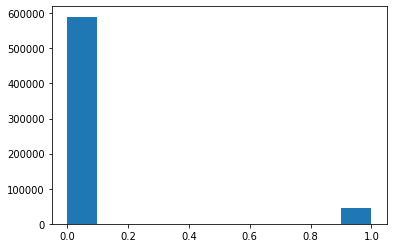

In [85]:
plt.hist(temp_predicted)

In [86]:
# Need to take classes and regenerate masks

# Determine orig. dimensions, reshape

temp_predicted.shape

(634880,)

In [87]:
full_numpy_dest = numpy_dest = os.path.join(hdd_data_dir, 'NumpyArraysLSmall2D_Incl_Zeros')
test_scan = np.load(os.path.join(full_numpy_dest, 'Flair_Array_64_Features.npy'))
test_scan_known = np.load(os.path.join(full_numpy_dest, 'Flair_Array_64_Classes.npy'))

[test_scan_reshaped] = resize_data([test_scan])


In [88]:
test_scan_reshaped.shape

(634880, 5, 5, 1)

In [89]:
temp_predicted = model.predict_classes(test_scan_reshaped)

(array([590231.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  44649.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

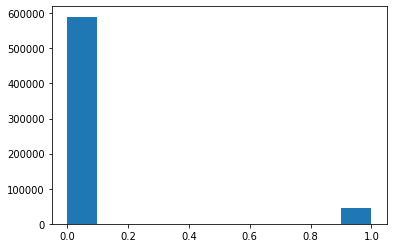

In [90]:
plt.hist(temp_predicted)

In [91]:
634880/64/64


155.0

In [98]:
temp_predicted = temp_predicted.reshape(64,64, 155)

In [99]:
temp_predicted.shape

(64, 64, 155)

In [100]:
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, origin="lower")

In [103]:
test_slice_1 = temp_predicted[:,:,70]
test_slice_2 = temp_predicted[:,:,80]


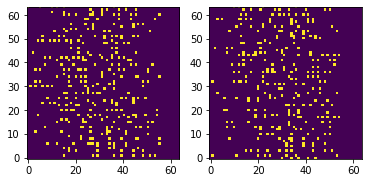

In [104]:
show_slices([test_slice_1, test_slice_2])